# Introduction

In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import re
import subprocess
from collections import Counter

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk.corpus

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import WordNetLemmatizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

try: 
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-emotion-classification-dataset/train-00000-of-00001.parquet
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [2]:
file_name = '/kaggle/input/twitter-emotion-classification-dataset/train-00000-of-00001.parquet'

full_data = pd.read_parquet(file_name)

In [3]:
full_data.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


# EDA, Data Cleaning, and Visualizations

#### I'll need to spend some time later this week figuring out a visualization plan for this data, how do I want to communicate information about a set as simple as some text and an emotion?

In [5]:
# Map of labels to emotions -- from dataset overview page: https://www.kaggle.com/datasets/aadyasingh55/twitter-emotion-classification-dataset/data
topic_mapping = {
    0:'sadness',
    1:'joy',
    2:'love',
    3:'anger',
    4:'fear',
    5:'surprise'
}
full_data['emotion'] = full_data['label'].map(topic_mapping)

In [6]:
full_data[['text', 'emotion']].head()

,text,emotion
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


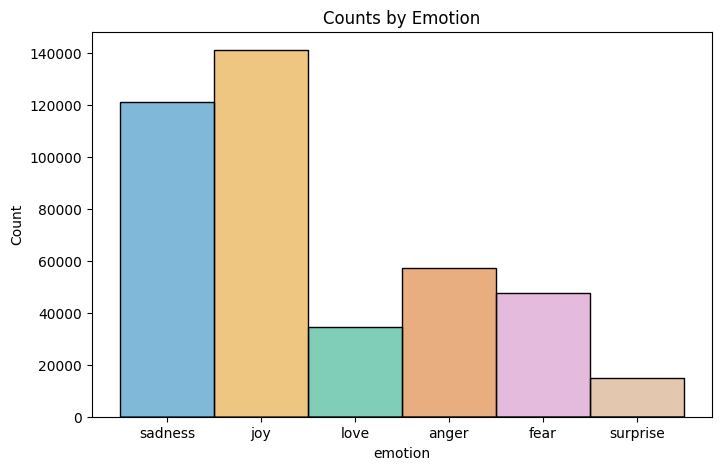

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(
    data = full_data,
    x = 'emotion',
    hue = 'emotion',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Counts by Emotion');

#### We have some very unbalanced categories here, we'll explore some upsampling techniques during training to see how it affects performance

## Stop words and Tokenizing

#### The text in the dataset has already undergone some cleaning, but we'll still do some extra cleaning: removing stop words and tokenizing the text

In [8]:
def clean_text(df, text_col):
    # remove any urls
    df['no_url'] = df[text_col].apply(lambda row: re.sub(r'https?://\S+|www\.\S+', '', row))
    
    # remove any punctuation
    df['no_punct'] = df['no_url'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    # get rid of numbers 
    df['no_punct_num'] = df['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    # remove any common words (this list was derived from the word frequency graphs below)
    common_words = ['feel', 'feeling', 'like', 'im', 'time']
    df['clean_text'] = df['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (common_words)]))

    # Drop the intermediary columns
    df.drop(['no_url', 'no_punct', 'no_punct_num'], axis=1, inplace=True)
    
    return 

In [9]:
clean_text(full_data, 'text')

In [10]:
full_data.head()

,text,label,emotion,clean_text
0,i feel awful about it too because it s my job ...,0,sadness,i awful about it too because it s my job to ge...
1,im alone i feel awful,0,sadness,alone i awful
2,ive probably mentioned this before but i reall...,1,joy,ive probably mentioned this before but i reall...
3,i was feeling a little low few days back,0,sadness,i was a little low few days back
4,i beleive that i am much more sensitive to oth...,2,love,i beleive that i am much more sensitive to oth...


In [11]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

def tokenize_lemmatize(text):
    tokens = tokenizer.tokenize(text)
    stop_words = stopwords.words('english')
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

In [12]:
full_data['tokens'] = full_data['clean_text'].apply(lambda x: tokenize_lemmatize(x))
full_data[['text', 'clean_text', 'tokens']].head()

,text,clean_text,tokens
0,i feel awful about it too because it s my job ...,i awful about it too because it s my job to ge...,awful job get position succeed happen
1,im alone i feel awful,alone i awful,alone awful
2,ive probably mentioned this before but i reall...,ive probably mentioned this before but i reall...,ive probably mentioned really proud actually k...
3,i was feeling a little low few days back,i was a little low few days back,little low day back
4,i beleive that i am much more sensitive to oth...,i beleive that i am much more sensitive to oth...,beleive much sensitive people feeling tend com...


## Word Frequencies and Other Goodies

#### we'll do some visualizations here eventually

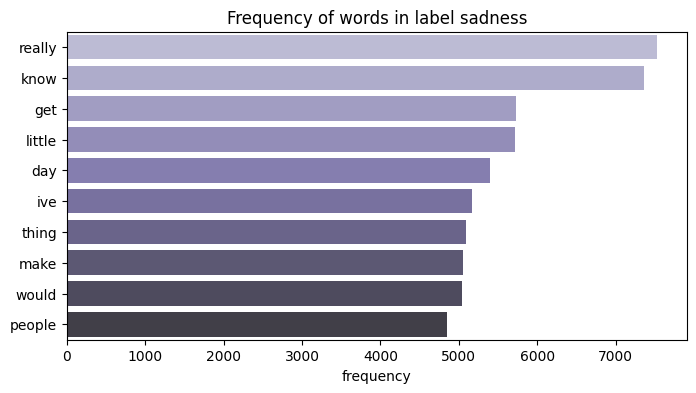

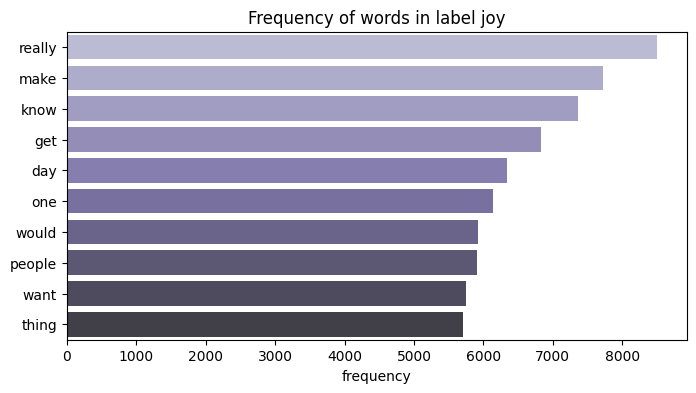

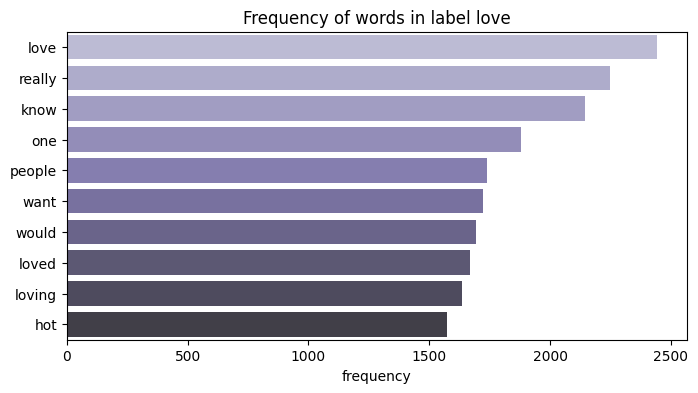

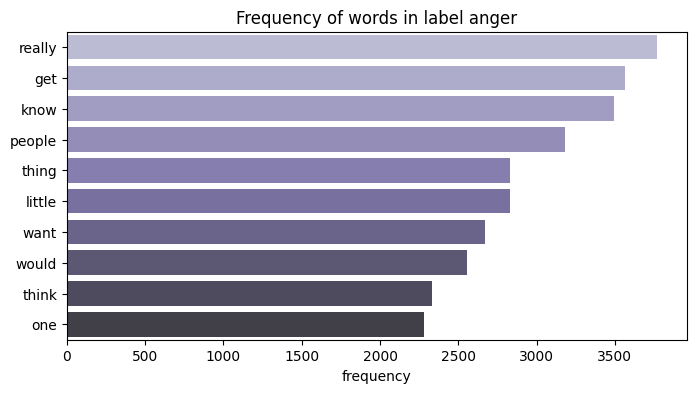

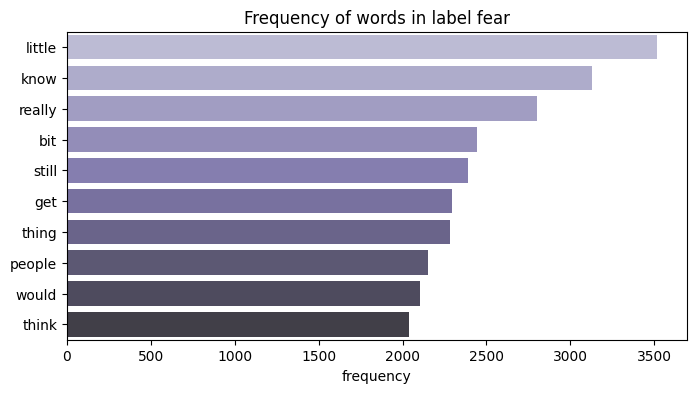

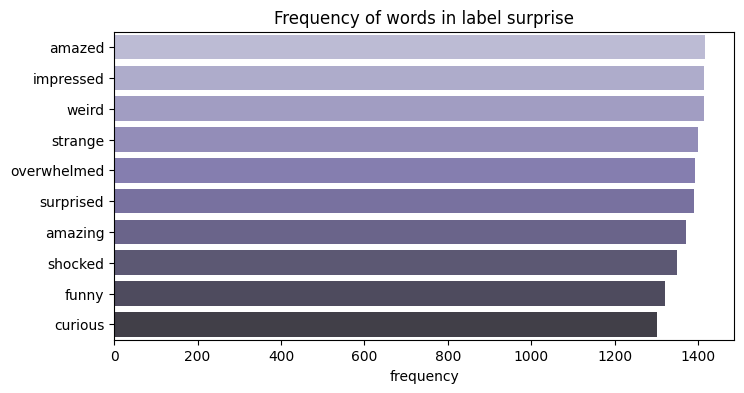

In [45]:
for label in full_data['emotion'].unique():

    text = " ".join(full_data[full_data['emotion'] == label]['tokens']).split()

    most_common = Counter(text).most_common(10)

    word, counts = zip(*most_common)



    plt.figure(figsize=(8,4))

    sns.barplot(x=list(counts), y=list(word), palette="Purples_d")

    plt.title(f"Frequency of words in label {label}")

    plt.xlabel('frequency')

    plt.show()

# Modeling and Predicting

#### The first thing we'll do is split into our Train/Test datasets. We have over 400,000 examples so a 75% train / 25% test split should be MORE than enough data for our needs

In [51]:
X_full = full_data['tokens']
y_full = full_data['label']

X_train, X_test, y_train, y_test = train_test_split(
        X_full,
        y_full,
        train_size = 0.75,
        random_state=4133,
        stratify=y_full
    )

## TD-IDF vs Bag-of-Words

In [23]:
tfid = TfidfVectorizer(min_df = 2, max_df = 0.90, norm = 'l2')

tfid_train = tfid.fit_transform(X_train)
train_features = tfid.get_feature_names_out()

tfid_test = tfid.fit_transform(X_test)
test_features = tfid.get_feature_names_out()

tfid_train.shape

(312606, 30493)

In [16]:
bagowords = CountVectorizer(min_df = 2, max_df = .90)
bag_train = bagowords.fit_transform(X_train)
bag_test = bagowords.fit_transform(X_test)

bag_train.shape

(312606, 30493)

## Unsupervised Methods

### Non-Negative Matrix Factorization

In [38]:
nmf_model = NMF(n_components=6, random_state=4133)
nmf_pred = nmf_model.fit_transform(tfid_train)

In [40]:
y_pred_nmf = nmf_pred.argmax(axis=1)
y_pred_nmf

max_acc, y_pred, mapping = 0, None, None
for p in itertools.permutations(range(6)):
    y_temp_transformed = [p[idx] for idx in y_pred_nmf]
    acc = accuracy_score(y_train['label'], y_temp_transformed)
    if (acc > max_acc):
        max_acc = acc
        y_pred = y_temp_transformed
        mapping = p
print("Max accuracy was: " + str(max_acc))
mapping

Max accuracy was: 0.2991369327524104


(1, 3, 4, 2, 0, 5)

{'joy', 'sadness', 'fear', 'surprise', 'love', 'anger'}
{'joy', 'sadness', 'fear', 'surprise', 'love', 'anger'}
Accuracy: 0.2991369327524104


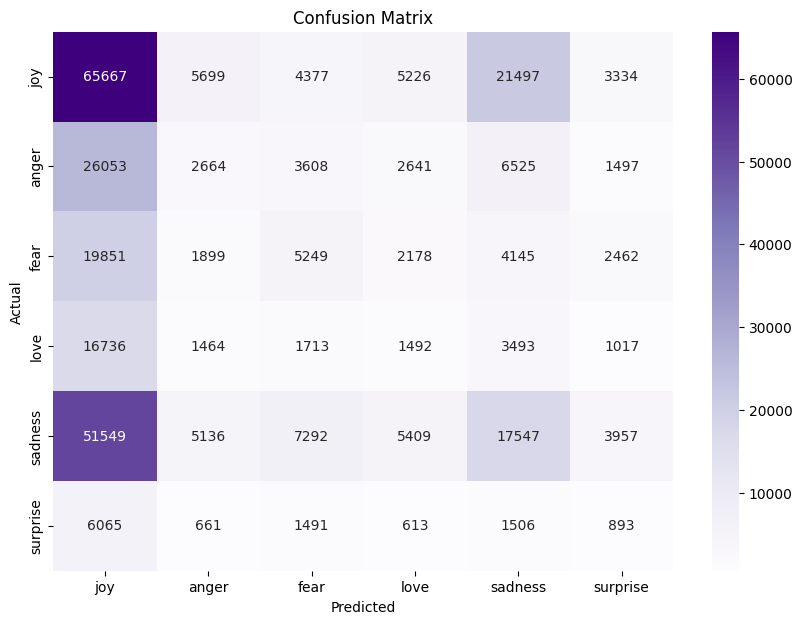

              precision    recall  f1-score   support

         joy       0.15      0.06      0.09     42988
       anger       0.22      0.15      0.18     35784
        fear       0.35      0.62      0.45    105800
        love       0.08      0.06      0.07     25915
     sadness       0.32      0.19      0.24     90890
    surprise       0.07      0.08      0.07     11229

    accuracy                           0.30    312606
   macro avg       0.20      0.19      0.18    312606
weighted avg       0.27      0.30      0.26    312606



In [44]:
'''
topic_mapping = {
    0:'sadness',
    1:'joy',
    2:'love',
    3:'anger',
    4:'fear',
    5:'surprise'
}
'''
emotion_to_category_mapping = {
    0: 'joy', 
    1: 'anger',  
    2: 'fear',  
    3: 'love',  
    4: 'sadness',
    5: 'surprise'
}

predicted_emotions = [emotion_to_category_mapping[emote] for emote in y_pred_nmf]

actual_emotions = y_train['emotion']

accuracy = accuracy_score(actual_emotions, predicted_emotions)

print(set(actual_emotions))
print(set(predicted_emotions))
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(actual_emotions, predicted_emotions, labels=list(emotion_to_category_mapping.values()))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=emotion_to_category_mapping.values(), yticklabels=emotion_to_category_mapping.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(actual_emotions, predicted_emotions, target_names=list(emotion_to_category_mapping.values()))
print(class_report)

### OH NO IT SUCKS
#### We'll resample the training set using SMOTE

In [64]:
tfid_train_resample, y_train_resample = NearMiss(version=3, n_jobs=-1).fit_resample(tfid_train, y_train)

In [65]:
print(f'Imbalanced class sampling: {Counter(y_train)}')
print(f'Balanced class sampling: {Counter(y_train_resample)}')

Imbalanced class sampling: Counter({1: 105800, 0: 90890, 3: 42988, 4: 35784, 2: 25915, 5: 11229})
Balanced class sampling: Counter({2: 11229, 5: 11229, 4: 10274, 1: 3307, 0: 2560, 3: 1334})


In [66]:
y_train_resample_emotes = [topic_mapping[label] for label in y_train_resample]
y_train_resample_emotes = np.array(y_train_resample_emotes)
y_train_resample_emotes

array(['sadness', 'sadness', 'sadness', ..., 'surprise', 'surprise',
       'surprise'], dtype='<U8')

#### We'll re-run the NMF method to see if performance is improved

In [67]:
nmf_model = NMF(n_components=6, random_state=4133)
nmf_pred = nmf_model.fit_transform(tfid_train_resample)

y_pred_nmf = nmf_pred.argmax(axis=1)

max_acc, y_pred, mapping = 0, None, None
for p in itertools.permutations(range(6)):
    y_temp_transformed = [p[idx] for idx in y_pred_nmf]
    acc = accuracy_score(y_train_resample, y_temp_transformed)
    if (acc > max_acc):
        max_acc = acc
        y_pred = y_temp_transformed
        mapping = p
print("Max accuracy was: " + str(max_acc))
mapping

Max accuracy was: 0.3517642050434478


(3, 0, 4, 1, 2, 5)

### Heirarchical Clustering

### K-Means Clustering

## Supervised Methods

# Comparisons and Conclusions